In [76]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps
from pysindy.differentiation import FiniteDifference
from pysindy.utils import enzyme, bacterial
import sympy as sp
from scipy.integrate import solve_ivp
import scipy

# ignore user warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# For reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

In [77]:
t = np.linspace(0, 1, 5)
x = np.ones((5, 2))

# Functions to be applied to the data x
functions = [lambda x: np.exp(x), lambda x, y: np.sin(x + y)]

# Functions to be applied to the data x_dot
x_dot_functions = [lambda x: x]

lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    t=t,
).fit(x)
lib.transform(x)
print("Without function names: ")
print(lib.get_feature_names(), "\n")

# Function names includes both the x and x_dot functions
function_names = [
    lambda x: "exp(" + x + ")",
    lambda x, y: "sin(" + x + y + ")",
    lambda x: x,
]
lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    function_names=function_names,
    t=t,
).fit(x)
lib.transform(x)
print("With function names: ")
print(lib.get_feature_names(), "\n")

# Now include a bias term (constant term)
lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    function_names=function_names,
    t=t,
    include_bias=True,
).fit(x)
lib.transform(x)
print("With function names and bias term: ")
print(lib.get_feature_names())

Without function names: 
['f0(x0)', 'f0(x1)', 'f1(x0,x1)', 'f_dot0(x0_dot)', 'f_dot0(x1_dot)', 'f0(x0)f_dot0(x0_dot)', 'f0(x1)f_dot0(x0_dot)', 'f1(x0,x1)f_dot0(x0_dot)', 'f0(x0)f_dot0(x1_dot)', 'f0(x1)f_dot0(x1_dot)', 'f1(x0,x1)f_dot0(x1_dot)'] 

With function names: 
['exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'x1_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot'] 

With function names and bias term: 
['1', 'exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'x1_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot']


### Solve 1D Michelson-Menten enzyme model as first demonstration
The Michelson-Menten enzyme model is,
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Note that, instead of dealing with fractional terms, it can be rearranged into
$$\dot{x} = \frac{3}{5} -3 x - \frac{10}{3} x\dot{x},$$
which is an implicit ODE, since the right-hand-side now depends on $\dot{x}$! In order to handle this scenario, SINDy-PI builds a candidate library with terms depending on both $x$ and $\dot{x}$, and solves the optimization problem, 
$$\|\Theta(x, \dot{x}) - \Theta(x, \dot{x})\Xi\|_2 + \lambda\|\Xi\|_1, \quad s.t. \text{diag}(\Xi) = 0.$$
This reason this modified optimization is required is that linear terms in $\dot{x}$ are no longer guaranteed, so every candidate library term is fit with a different model to find the best combination of implicit terms. Note $\text{diag}(\Xi) = 0$ is required because without this, the model would just fit every candidate library term with itself, $\dot{x} = \dot{x}$, $x\dot{x} = x\dot{x}$, $x^2\dot{x} = x^2\dot{x}$, and so on.

In [78]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T

In [79]:
x_train.shape, enzyme

((4002, 1),
 <function pysindy.utils.odes.enzyme(t, x, jx=0.6, Vmax=1.5, Km=0.3)>)

In [88]:
# Initialize custom SINDy library so that we can have x_dot inside it.
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both
# the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x,
]

In [89]:
# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t[1:-1],
    function_names=library_function_names,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly,
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=30000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

Model  0
Model  1
Model  2
Model  3
Solver failed on model  3 , setting coefs to zeros
Model  4
Model  5
Model  6
Model  7
Model  8
Model  9
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.508 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


In [90]:
model.complexity

90

### Okay, so how to choose which model to use?
So SINDy-PI has generated a different dynamical model for each of the candidate library terms, but how do we choose which one to use? This can be decided in many ways, but an easy choice is picking the model that minimizes the mean-squared error of the $\dot{x}$ testing data. There are many other ways to choose, and the SINDy-PI paper noted that bad models tend to also be less sparse, so sparsity is another metric for selection. Below, we simply integrate forward all the models and on this testing trajectory, they basically all perform fine. 


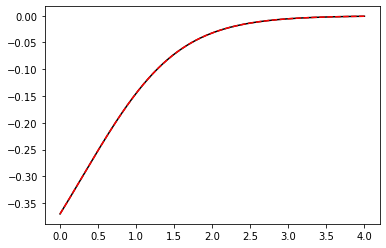

In [71]:
# Plot the fit of the derivative
x_dot_train = model.differentiate(x_train, t)
x_dot_train_pred = sindy_opt.Theta_ @ sindy_opt.coef_.T
plt.figure()
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t, x_dot_train[:, i], "k")
    plt.plot(t[1:-1], x_dot_train_pred[:, 5], "r--")

In [72]:
model.get_feature_names()

['1',
 'x',
 'x0x0',
 'x0x0x0',
 'x0x0x0x0',
 'x0_dot',
 'xx0_dot',
 'x0x0x0_dot',
 'x0x0x0x0_dot',
 'x0x0x0x0x0_dot']

In [63]:
features = model.get_feature_names()
features[0] = "1"
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
print(features)
print(features_formatted)
coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]

['1', 'x0', 'x0x0', 'x0x0x0', 'x0x0x0x0', 'x0_dot', 'x0x0_dot', 'x0x0x0_dot', 'x0x0x0x0_dot', 'x0x0x0x0x0_dot']
['1', 'x0', 'x0 * x0', 'x0 * x0 * x0', 'x0 * x0 * x0 * x0', 'x0_dot', 'x0 * x0_dot', 'x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0 * x0_dot']


In [64]:
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    sym_equations.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 10)), sym_features[i]
        )
    )
    sym_equations_rounded.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 2)), sym_features[i]
        )
    )
    print(sym_theta[i], " = ", sym_equations_rounded[i][0])

1  =  5.0*x0 + 1.67*x0_dot + 5.56*x0x0_dot
x0  =  0.2*1 - 0.33*x0_dot - 1.11*x0x0_dot
x0x0  =  0.2*x0 - 0.34*x0x0_dot + 0.01*x0x0x0 - 1.1*x0x0x0_dot
x0x0x0  =  0
x0x0x0x0  =  0.04*x0x0_dot + 0.36*x0x0x0 - 1.21*x0x0x0x0x0_dot
x0_dot  =  0.6*1 - 3.0*x0 - 3.33*x0x0_dot
x0x0_dot  =  0.18*1 - 0.9*x0 - 0.3*x0_dot
x0x0x0_dot  =  0.14*x0 - 0.51*x0x0 - 0.1*x0x0_dot - 0.34*x0x0x0 - 0.22*x0x0x0x0x0_dot
x0x0x0x0_dot  =  -0.11*x0x0_dot - 0.39*x0x0x0 - 0.25*x0x0x0x0
x0x0x0x0x0_dot  =  -0.01*x0_dot + 0.03*x0x0_dot - 0.27*x0x0x0_dot - 0.67*x0x0x0x0


In [65]:
sym_equations[5], np.around(coefs[5], 3)

([0.5999817751*1 - 2.9999405642*x0 + 0.0001546073*x0x0 - 3.3330362204*x0x0_dot - 3.75e-8*x0x0x0 - 7.61e-8*x0x0x0x0 + 3.38e-8*x0x0x0x0_dot + 5.16e-8*x0x0x0x0x0_dot],
 array([ 0.6  , -3.   ,  0.   , -0.   , -0.   , -0.   , -3.333, -0.   ,
         0.   ,  0.   ]))

In [66]:
sym_equations_rounded[5]

[0.6*1 - 3.0*x0 - 3.33*x0x0_dot]

In [67]:
# Define the ODE symbol variables
t_sym = sp.symbols("t_sym")
x_sym = sp.symbols("x:%d" % r)
x_dot_sym = sp.symbols("x:%d_dot" % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
sym_equations_rounded_formatted = []
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_rounded_string = str(sym_equations_rounded[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        sym_equations_formatted.append(temp_string)
        sym_equations_rounded_formatted.append(temp_rounded_string)

5.4e-06 
 1 = 100.0*(1.0 - 5.0*x0)/(556.0*x0 + 167.0)

0.0001865 
 x0 = 6.67*(1.0 - 5.0*x0)/(37.0*x0 + 11.0)

0.013639 
 x0**2 = 0.5*(x0**2 - 100.0*x0 + 20.0)/(55.0*x0 + 17.0)

0.4019716 
 x0**4 = x0**2*(36.0 - 100.0*x0)/(121.0*x0**3 - 4.0)

0.0002485 
 x0_dot = 60.0*(1.0 - 5.0*x0)/(333.0*x0 + 100.0)

0.0006224 
 x0*x0_dot = 1.8*(1.0 - 5.0*x0)/(10.0*x0 + 3.0)

0.232742 
 x0**2*x0_dot = 0.5*(-34.0*x0**2 - 51.0*x0 + 14.0)/(11.0*x0**3 + 50.0*x0 + 5.0)

0.1792438 
 x0**3*x0_dot = x0**2*(-25.0*x0 - 39.0)/(100.0*x0**2 + 11.0)

0.0704214 
 x0**4*x0_dot = -67.0*x0**4/(100.0*x0**4 + 27.0*x0**2 - 3.0*x0 + 1.0)



Best equation:  1 = 100.0*(1.0 - 5.0*x0)/(556.0*x0 + 167.0)


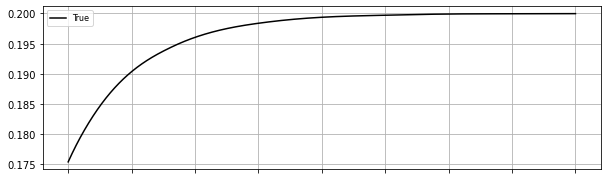

In [68]:
# Now that the equations are mathematically formatted,
# solve for x_dot0 in the algebraic equation.
sym_equations_simplified = []
sym_equations_rounded_simplified = []
for i in range(nfeatures):
    sym_equations_simplified.append(
        sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym,
        )
    )
    rounded = sp.solve(
        sp.Add(
            sp.sympify(sym_equations_rounded_formatted)[i][0],
            -sp.sympify(features_formatted[i]),
        ),
        x_dot_sym,
    )
    if len(rounded) != 0:
        rounded_temp = rounded[0]
        for a in sp.preorder_traversal(rounded):
            if isinstance(a, sp.Float):
                rounded_temp = rounded_temp.subs(a, round(a, 2))
        sym_equations_rounded_simplified.append(rounded_temp)
    else:
        sym_equations_rounded_simplified.append([])

# Plot the results for each of the models
plt.figure(figsize=(10, 3))
# plt.figure(figsize=(30, 30))
x0_test = np.random.rand(1)
x_test = solve_ivp(enzyme, t_span, x0_test, t_eval=t).y.T
plt.plot(t, x_test, color="k", linestyle="solid", label="True")

_min = float("inf")
best_eq = None

for i in range(nfeatures):
    ax = plt.gca()
    if i != nfeatures - 1:
        ax.set_xticklabels([])
    if len(sym_equations_simplified[i]) != 0:
        ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[i][0])

        # Now simulate the system we identified
        x_test_sim = solve_ivp(ODE_Func, t_span, x0_test, t_eval=t).y.T

        fit = abs(np.around(np.sum(x_test - x_test_sim), 7))
        eq = (
            str(sp.sympify(features_formatted[i]))
            + " = "
            + str(sym_equations_rounded_simplified[i])
        )
        print(abs(np.around(fit, 7)), "\n", eq)
        print()

        if _min > fit:
            _min = fit
            best_eq = eq

print("\n\nBest equation: ", best_eq)
plt.grid(True)

plt.legend(fontsize=8)